In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, log_loss

In [2]:
df = pd.read_csv("/Users/jacobemerson/Code/my_projects/credit_risk_model/data/loan_data.csv")

In [3]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

In [4]:
rename_map = {
    "person_age": "age",
    "person_gender": "gender",
    "person_education": "education",
    "person_income": "income",
    "person_emp_exp": "emp_exp",
    "person_home_ownership": "home_ownership",
    "loan_amnt": "loan_amount",
    "loan_intent": "loan_intent",
    "loan_int_rate": "loan_rate",
    "loan_percent_income": "loan_perc_income",
    "cb_person_cred_hist_length": "credit_history",
    "credit_score": "credit_score",
    "previous_loan_defaults_on_file": "loan_defaults",
    "loan_status": "loan_status"
}


In [5]:
df = df.rename(columns=rename_map)

In [6]:
df.head()

,age,gender,education,income,emp_exp,home_ownership,loan_amount,loan_intent,loan_rate,loan_perc_income,credit_history,credit_score,loan_defaults,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [7]:
#define X and y variables
target_col = "loan_status"
X = df.drop(columns=target_col)
y = df[target_col]

In [8]:
# Identify column types
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()
numerical_cols = X.select_dtypes(include=["number"]).columns.tolist()

# Preprocessing

In [ ]:
# One-hot code categorical columns only 
preprocessor = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), numerical_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore"))
        ]), categorical_cols),
    ]
)

In [ ]:
# 1) Train + temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

# 2) Validation + test (split temp in half)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

# Model

In [ ]:
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [ ]:
pipeline = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", model)
])

In [ ]:
pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('prep', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('num', ...), ('cat', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'drop'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transformers contains s

In [ ]:
threshold = 0.8
y_val_proba = pipeline.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_proba >= threshold).astype(int)

# Optimization

In [ ]:
# Precision-Recall Trade Off when threshold changes

threshold = 0.40
y_pred_thr = (y_val_proba >= threshold).astype(int)

print("Precision:", precision_score(y_test, y_pred_thr))
print("Recall:", recall_score(y_test, y_pred_thr))


Precision: 0.23643670462156732
Recall: 0.23533333333333334


In [ ]:
def find_best_threshold_by_profit(
    y_true,
    y_proba,
    profit_per_good_loan,
    loss_per_default,
    thresholds=None
):
    # y_true: true labels (1 = good loan, 0 = bad loan)
    # y_proba: predicted probability of class 1
    # profit = TP * profit_per_good_loan - FP * loss_per_default

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.99, 99)

    rows = []
    N = len(y_true)

    for t in thresholds:
        y_pred = (y_proba >= t).astype(int)

        # Confusion matrix order: [[TN, FP], [FN, TP]]
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        expected_profit = tp * profit_per_good_loan - fp * loss_per_default
        approval_rate = (tp + fp) / N

        rows.append({
            "threshold": t,
            "tp": tp,
            "fp": fp,
            "tn": tn,
            "fn": fn,
            "approval_rate": approval_rate,
            "expected_profit": expected_profit
        })

    results = pd.DataFrame(rows)

    best = results.loc[results["expected_profit"].idxmax()]

    return results, float(best["threshold"]), best


In [ ]:
val_proba = pipeline.predict_proba(X_val)[:, 1]

results, best_threshold, best_row = find_best_threshold_by_profit(
    y_true=y_val,
    y_proba=val_proba,
    profit_per_good_loan=10000,
    loss_per_default=80000
)

In [ ]:
pipeline.best_threshold_ = best_threshold

In [ ]:
test_proba = pipeline.predict_proba(X_test)[:, 1]
y_test_pred = (test_proba >= pipeline.best_threshold_).astype(int)

In [ ]:
def plot_expected_profit(results, best_threshold):
    """
    Plot expected profit vs threshold and mark the best threshold.

    Parameters
    ----------
    results : pd.DataFrame
        Must contain columns ['threshold', 'expected_profit']
    best_threshold : float
        Threshold that maximizes expected profit
    """

    plt.figure(figsize=(8, 5))

    plt.plot(
        results["threshold"],
        results["expected_profit"],
        label="Expected Profit"
    )

    plt.axvline(
        x=best_threshold,
        color="red",
        linestyle="--",
        linewidth=2,
        label=f"Best threshold = {best_threshold:.2f}"
    )

    plt.xlabel("Threshold")
    plt.ylabel("Expected Profit")
    plt.title("Expected Profit vs Threshold")
    plt.legend()
    plt.grid(True)
    plt.show()



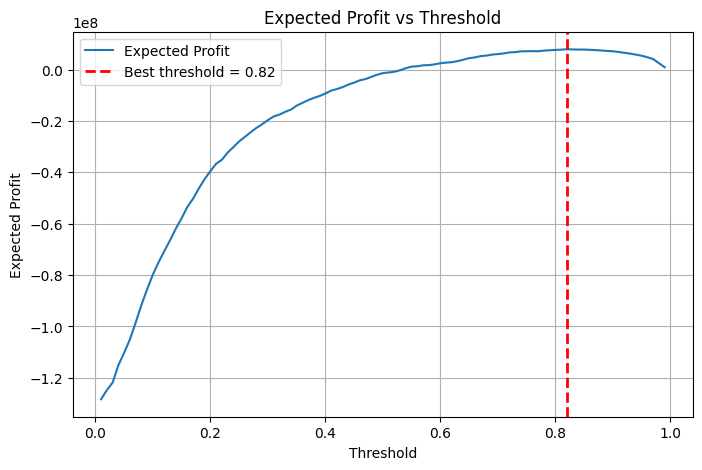

In [ ]:
plot_expected_profit(results, best_threshold)


In [ ]:
# feature_names = pipeline.named_steps["prep"].get_feature_names_out()
# importances = pipeline.named_steps["model"].feature_importances_

# feature_importance = (
#     pd.DataFrame({
#         "feature": feature_names,
#         "importance": importances
#     })
#     .sort_values("importance", ascending=False)
#     .reset_index(drop=True)
# )

# feature_importance.head(20)

,feature,importance
0,cat__loan_defaults_No,0.294799
1,num__loan_perc_income,0.177248
2,num__loan_rate,0.174235
3,cat__loan_defaults_Yes,0.155686
4,num__income,0.095564
5,cat__home_ownership_RENT,0.060539
6,num__credit_score,0.010286
7,cat__home_ownership_OWN,0.009837
8,cat__loan_intent_HOMEIMPROVEMENT,0.004994
9,cat__loan_intent_VENTURE,0.004369


# Model Performance Analysis

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="accuracy",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)


In [ ]:
train_mean = train_scores.mean(axis=1)
train_std  = train_scores.std(axis=1)

val_mean = val_scores.mean(axis=1)
val_std  = val_scores.std(axis=1)

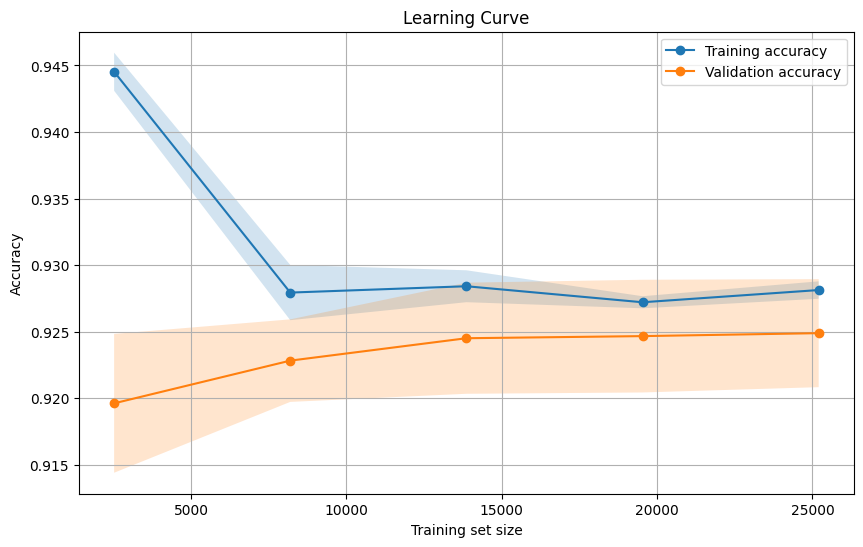

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(train_sizes, train_mean, marker="o", label="Training accuracy")
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)

plt.plot(train_sizes, val_mean, marker="o", label="Validation accuracy")
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)

plt.title("Learning Curve")
plt.xlabel("Training set size")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
    "roc_auc": roc_auc_score(y_test, test_proba),
    "log_loss": log_loss(y_test, test_proba)
}

In [ ]:
confusion_matrix(y_test, y_test_pred)

array([[5231,   19],
       [ 654,  846]])

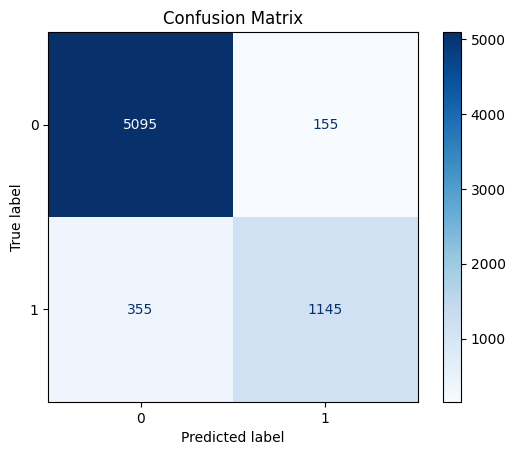

In [ ]:
ConfusionMatrixDisplay.from_estimator(
    pipeline,          # or model if already fit
    X_test,
    y_test,
    cmap="Blues",
    values_format="d"  # integers
)

plt.title("Confusion Matrix")
plt.show()

In [ ]:
list(zip(metrics.keys(), metrics.values()))

[('accuracy', 0.9002962962962963),
 ('precision', 0.9780346820809248),
 ('recall', 0.564),
 ('f1', 0.7154334038054968),
 ('roc_auc', 0.9706255238095238),
 ('log_loss', 0.17563506333036602)]

In [ ]:
feature_names = pipeline.named_steps["prep"].get_feature_names_out()
importances = pipeline.named_steps["model"].feature_importances_

In [ ]:
feature_names = [
    rename_map.get(col, col) for col in feature_names
]

In [ ]:
feature_names

['num__age',
 'num__income',
 'num__emp_exp',
 'num__loan_amount',
 'num__loan_rate',
 'num__loan_perc_income',
 'num__credit_history',
 'num__credit_score',
 'cat__gender_female',
 'cat__gender_male',
 'cat__education_Associate',
 'cat__education_Bachelor',
 'cat__education_Doctorate',
 'cat__education_High School',
 'cat__education_Master',
 'cat__home_ownership_MORTGAGE',
 'cat__home_ownership_OTHER',
 'cat__home_ownership_OWN',
 'cat__home_ownership_RENT',
 'cat__loan_intent_DEBTCONSOLIDATION',
 'cat__loan_intent_EDUCATION',
 'cat__loan_intent_HOMEIMPROVEMENT',
 'cat__loan_intent_MEDICAL',
 'cat__loan_intent_PERSONAL',
 'cat__loan_intent_VENTURE',
 'cat__loan_defaults_No',
 'cat__loan_defaults_Yes']

In [ ]:
feature_importance = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)


top_n = 10

feature_importance.head(top_n).plot(
    kind="barh",
    x="feature",
    y="importance",
    legend=False,
    figsize=(8, 5)
)

plt.gca().invert_yaxis()
plt.title(f"Top {top_n} Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


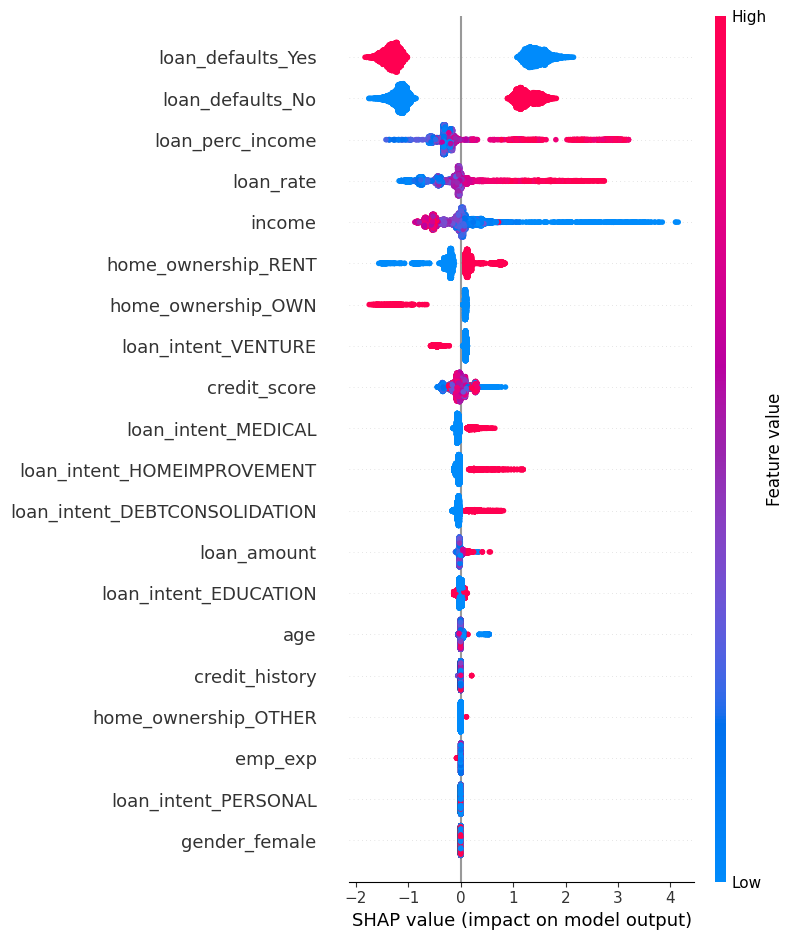

In [ ]:
import shap

X_test_enc = pipeline.named_steps["prep"].transform(X_test)
model = pipeline.named_steps["model"]

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_enc)


# grab the fitted OneHotEncoder directly
ohe = pipeline.named_steps["prep"].named_transformers_["cat"]

# get output feature names
feature_names = numerical_cols + list(ohe.get_feature_names_out(categorical_cols))

shap.summary_plot(shap_values, X_test_enc, feature_names=feature_names)



In [ ]:
X_test_enc[1]

array([2.2000e+01, 3.2784e+04, 3.0000e+00, 1.0000e+04, 1.5410e+01,
       3.1000e-01, 2.0000e+00, 5.2500e+02, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       1.0000e+00, 0.0000e+00])

In [ ]:
i = 6 # pick a row index

sv = shap_values[i]  # if shap_values is (n_samples, n_features)
top = np.argsort(np.abs(sv))[::-1][:10]  # top 10 by absolute impact

pd.DataFrame({
    "feature": np.array(feature_names)[top],
    "value": (X_test_enc[i, top].A1 if hasattr(X_test_enc, "A1") else X_test_enc[i, top]),
    "shap": sv[top],
    "abs_shap": np.abs(sv[top])
}).sort_values("abs_shap", ascending=False)


,feature,value,shap,abs_shap
0,loan_defaults_Yes,1.00,-1.444813,1.444813
1,loan_defaults_No,0.00,-1.178075,1.178075
2,credit_score,567.00,-0.344069,0.344069
3,loan_perc_income,0.06,-0.317598,0.317598
4,loan_rate,8.90,-0.247556,0.247556
5,income,43059.00,0.178925,0.178925
6,loan_intent_MEDICAL,1.00,0.144938,0.144938
7,home_ownership_RENT,1.00,0.099029,0.099029
8,loan_intent_VENTURE,0.00,0.092356,0.092356
9,home_ownership_OWN,0.00,0.082184,0.082184


In [ ]:
# --- DiCE counterfactuals (drop into a Jupyter cell) ---
# Assumes you already have:
#   - df: pandas DataFrame with ALL feature columns + outcome column
#   - model: your trained classifier
#   - X_applicant: a SINGLE-ROW pandas DataFrame of the applicant features (same columns as training features)

%pip -q install dice-ml

import dice_ml
from dice_ml import Dice

# -----------------------------
# 1) CONFIG — EDIT THESE
# -----------------------------
OUTCOME_COL = "approved"          # name of target column in df (0/1)
MODEL_BACKEND = "sklearn"         # "sklearn" | "xgboost" | "lightgbm" | "catboost"

# Put your feature names here
continuous_features = [
    # e.g. "income", "debt_to_income", "credit_history_years"
]

categorical_features = [
    # e.g. "employment_type", "home_ownership"
]

# Optional: protect immutable/sensitive features by NOT allowing them to vary
immutable_features = [
    # e.g. "age", "gender"
]

# Optional: realistic ranges for changeable numeric features
permitted_range = {
    # e.g. "debt_to_income": [0.0, 0.40],
    #      "income": [20000, 250000]
}

# Optional: explicitly choose which features DiCE is allowed to change
features_to_vary = [
    # e.g. "income", "debt_to_income"
]
# -----------------------------

# -----------------------------
# 2) BUILD DiCE DATA + MODEL OBJECTS
# -----------------------------
dice_data = dice_ml.Data(
    dataframe=df,
    continuous_features=continuous_features,
    categorical_features=categorical_features,
    outcome_name=OUTCOME_COL
)

dice_model = dice_ml.Model(
    model=model,
    backend=MODEL_BACKEND,
    model_type="classifier"
)

# method="random" is a solid default; try "genetic" if you want better counterfactual search (sometimes slower).
dice = Dice(dice_data, dice_model, method="random")

# -----------------------------
# 3) GENERATE COUNTERFACTUALS
# -----------------------------
# Decide what outcome you want:
# - desired_class=1 to find "approved" counterfactuals
# - desired_class=0 to find "denied" counterfactuals
desired_class = 1
total_CFs = 3

# Build features_to_vary_final (exclude immutable features automatically if you didn't specify a list)
if features_to_vary:
    features_to_vary_final = [f for f in features_to_vary if f not in immutable_features]
else:
    # If not provided, allow all features except immutable ones
    features_to_vary_final = [c for c in X_applicant.columns if c not in immutable_features]

cf = dice.generate_counterfactuals(
    query_instance=X_applicant,
    total_CFs=total_CFs,
    desired_class=desired_class,
    features_to_vary=features_to_vary_final,
    permitted_range=permitted_range if permitted_range else None
)

# View results nicely in notebook
cf.visualize_as_dataframe()

# -----------------------------
# 4) EXTRACT RESULTS AS A DATAFRAME
# -----------------------------
cf_df = cf.cf_examples_list[0].final_cfs_df
cf_df


Note: you may need to restart the kernel to use updated packages.


UserConfigValidationException: outcome_name approved not found in age,gender,education,income,emp_exp,home_ownership,loan_amount,loan_intent,loan_rate,loan_perc_income,credit_history,credit_score,loan_defaults,loan_status